# Main Idea:
We are going to train each model on two different classes, making a binary classification problem, then we will use liquid
democracy to delegate the the model that is the best on the test set at a given time.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from scipy import stats
import ensemble as ens
from ensemble import Ensemble

from importlib import reload
reload(ens)

<module 'ensemble' from '/Users/ben/VSCode/banditLiquidDem/covariate_shift/ensemble.py'>

In [2]:

# Set ensemble parameters - division of classes, number of models, and how long to train
# train_digit_groups = [[0,1], [2,3], [4,5], [6,7], [8,9]]
# test_digit_groups = [[0,1,2,3,4], [5,6,7,8,9]]
train_digit_groups = [[0,1,2], [2,3,4], [0,1,3,4], [5,6,7], [7,8,9], [5,6,8,9]]
test_digit_groups = [[0,1,2,3,4], [5,6,7,8,9]]
models_per_loader = 3
training_epochs = 1
batch_size = 64

window_size = 10

In [3]:
ensemble = Ensemble(models_per_train_digit_group=models_per_loader, 
                        training_epochs=training_epochs, 
                        batch_size=batch_size,
                        window_size=window_size,
                        train_digit_groups=train_digit_groups, 
                        test_digit_groups=test_digit_groups)

ensemble.prepare_loaders()
# ensemble.train_models()

# train_loaders = ens.prepare_train_loaders(mnist_train, digit_groups=train_digit_groups)
# test_loader, split_indices = ens.prepare_test_loaders(mnist_test, digit_groups=test_digit_groups)

In [4]:
# train_models()
models = ensemble.train_models()

100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


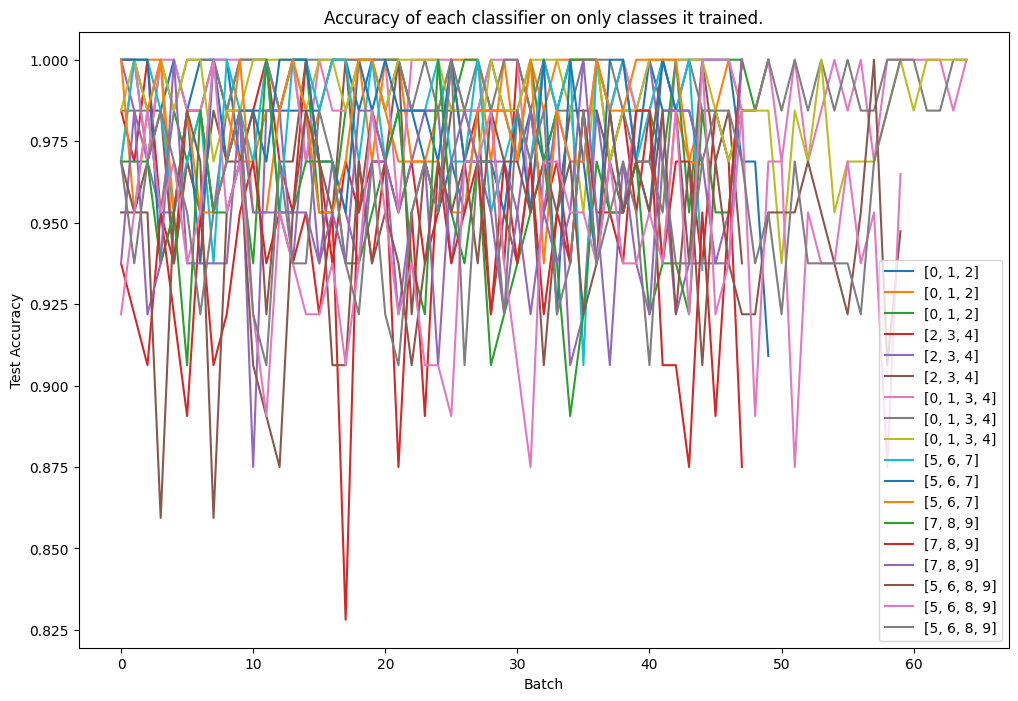

In [5]:
# Calculate test accuracy on each voter's respective classes
model_idx = 0
evaluation_loaders, splits = ensemble.prepare_test_loaders(digit_groups=train_digit_groups)

model_accuracies = dict()
for train_group_idx, train_group in enumerate(train_digit_groups):
    loader = ensemble.test_loaders[train_group_idx]
# for loader in evaluation_loaders:
    for _ in range(models_per_loader):
        model = models[model_idx]
        model_batch_accuracies = []

        for data, target in loader:
            data, target = data.to(ensemble.device), target.to(ensemble.device)

            predictions = model.predict(data)
            point_wise_accuracies = (predictions == target).float().tolist()

            model_batch_accuracies.append(sum(point_wise_accuracies) / len(point_wise_accuracies))
        
        model_accuracies[model_idx] = (str(train_group), model_batch_accuracies)
        model_idx += 1



# Plot each model's accuracy on the classes it is trained on
plt.figure(figsize=(12, 8))

for label, accs in model_accuracies.values():
    plt.plot(accs, label=label)

plt.xlabel("Batch")
plt.ylabel("Test Accuracy")
plt.title("Accuracy of each classifier on only classes it trained.")
plt.legend()
plt.show()


# Graph is not super useful but pretty clearly shows that individual classifier accuracy is very high
# (assuming this quick code is correct)

In [6]:
voters = []

UCBs_over_time = {i:[] for i in range(len(models))}

for i in range(len(models)):
    voters.append(ens.Voter(models[i], i))

delegation_mechanism = ens.DelegationMechanism(batch_size=batch_size, window_size=window_size)

liquid_dem_proba_accs = []
liquid_dem_vote_accs = []
liquid_dem_weighted_vote_accs = []
full_ensemble_accs = []

# Warm start
# # Take some small random samples from the test set and use them to warm start the delegation mechanism
# for i in range(1000):
#     # get a random sample from the test set
#     rand_idx = np.random.randint(0, len(mnist_test))
#     data, target = mnist_test[rand_idx]

#     # get all of the voters to to predict and update thier accuracies and CIs
#     for voter in voters:
#         predictions = voter.predict(data)
#         point_wise_accuracies = (predictions == target).float().tolist()
#         voter.accuracy.extend(point_wise_accuracies)
#         voter.CI = delegation_mechanism.calculate_CI(voter)


# Calculate test accuracy on the first set of test digits
for data, target in tqdm(ensemble.test_loaders[0]):
    data, target = data.to(ensemble.device), target.to(ensemble.device)

    gurus = delegation_mechanism.get_gurus(voters)

    # Get guru accuracies (at pointwise and batch levels)
    for guru in gurus:
        predictions = guru.predict(data)

        point_wise_accuracies = (predictions == target).float().tolist()
        guru.accuracy.extend(point_wise_accuracies)

        guru.batch_accuracies.append(
            sum(point_wise_accuracies) / len(point_wise_accuracies)
        )

    # get all of the gurus to predict then take the majority vote
    liquid_dem_preds = []
    for guru in gurus:
        guru_pred = guru.predict(data)

        # find number of delegations (TODO: not quite correct, needs to allow for transitivity)
        guru_weight = 0
        for delegator, delegee in delegation_mechanism.delegations.items():
            if delegee == guru.id:
                guru_weight += 1
        if guru_weight == 0:
            guru_weight = 1
        for i in range(guru_weight):    # append one "vote" per weight of each guru
            liquid_dem_preds.append(guru_pred)

    liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
    # take the majority vote - WEIGHTED VERSION
    liquid_dem_preds = torch.mode(liquid_dem_preds, dim=1)[0]
    liquid_dem_weighted_vote_accs.append(
        (liquid_dem_preds == target).float().mean().item()
    )

    # get all of the gurus to predict then take the majority vote -- UNWEIGHTED VERSION
    liquid_dem_preds = []
    for guru in gurus:
        liquid_dem_preds.append(guru.predict(data))
    liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
    # take the majority vote
    liquid_dem_preds = torch.mode(liquid_dem_preds, dim=1)[0]
    liquid_dem_vote_accs.append((liquid_dem_preds == target).float().mean().item())

    probas = []
    for guru in gurus:
        probas.append(guru.predict_proba(data))
    probas = torch.stack(probas).transpose(0, 1)
    # take the average of class probabilities - CURRENTLY UNWEIGHTED
    probas = torch.mean(probas, dim=1)
    # take the highest probability
    liquid_dem_preds = torch.argmax(probas, dim=1)
    liquid_dem_proba_accs.append((liquid_dem_preds == target).float().mean().item())

    # # get every voter to predict and extend their accuracies
    # for voter in voters:
    #     predictions = voter.predict(data)
    #     point_wise_accuracies = (predictions == target).float().tolist()
    #     voter.accuracy.extend(point_wise_accuracies)

    # get all of the models to predict then take the majority vote
    full_ensemble_preds = []
    for model in models:
        full_ensemble_preds.append(model.predict(data))
    full_ensemble_preds = torch.stack(full_ensemble_preds).transpose(0, 1)
    # take the majority vote
    full_ensemble_preds = torch.mode(full_ensemble_preds, dim=1)[0]
    full_ensemble_accs.append((full_ensemble_preds == target).float().mean().item())

    # print(delegation_mechanism.delegations)

    # add the CIs to the dictionary
    for voter in voters:
        UCBs_over_time[voter.id].append(voter.ucb_score)

    delegation_mechanism.t += len(data)

    delegation_mechanism.update_delegations(voters)


100%|██████████| 50/50 [00:00<00:00, 76.21it/s]


In [7]:
print(delegation_mechanism.delegations)

{}


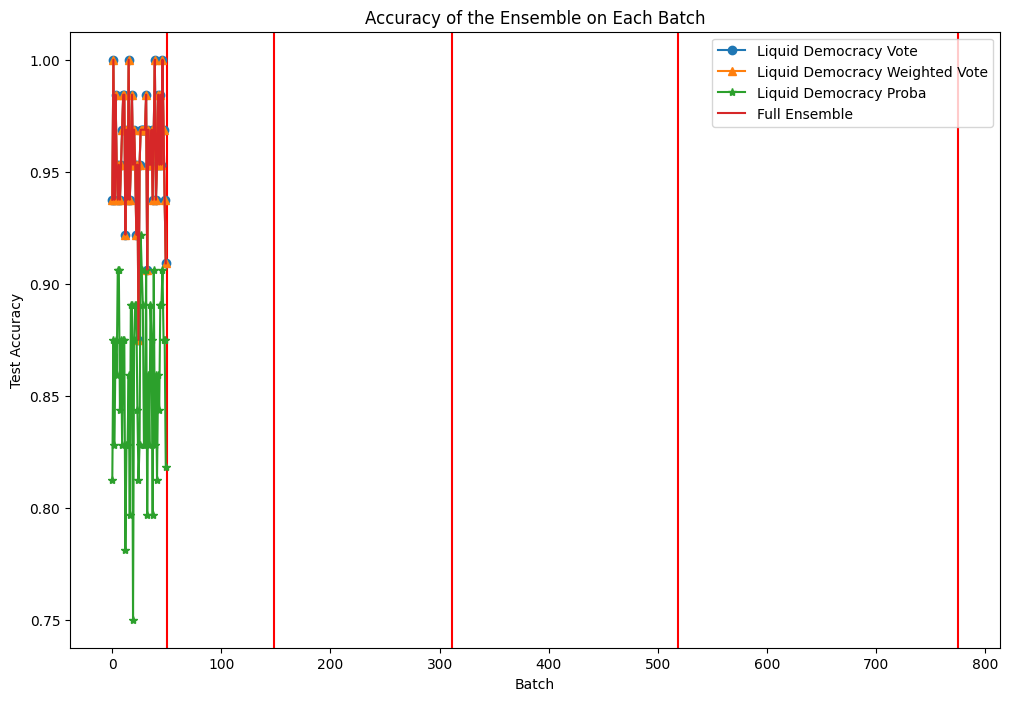

In [8]:
# Plot test accuracy on the first set of digits

plt.figure(figsize=(12, 8))
for split in ensemble.test_split_indices[:-1]:
    plt.axvline(x=split, color="r")

plt.plot(liquid_dem_vote_accs, marker="o", label="Liquid Democracy Vote")
plt.plot(
    liquid_dem_weighted_vote_accs, marker="^", label="Liquid Democracy Weighted Vote"
)
plt.plot(liquid_dem_proba_accs, marker="*", label="Liquid Democracy Proba")
plt.plot(full_ensemble_accs, label="Full Ensemble")
plt.xlabel("Batch")
plt.ylabel("Test Accuracy")
plt.title("Accuracy of the Ensemble on Each Batch")
plt.legend()
plt.show()

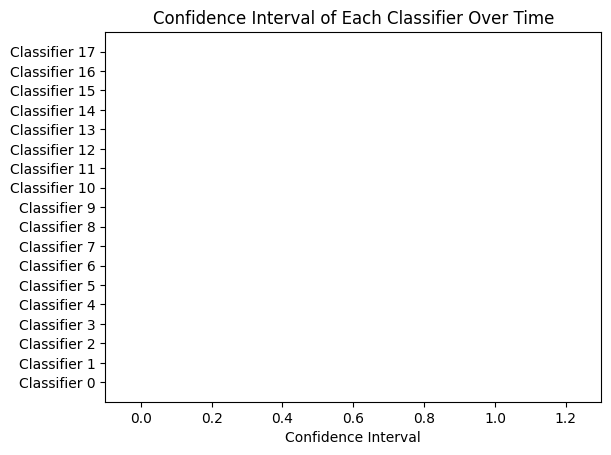

In [9]:
# Number of classifiers and time steps
num_classifiers = len(UCBs_over_time)
num_timesteps = len(UCBs_over_time[0])

# Initialize figure and axis
fig, ax = plt.subplots()

# Set labels and title
ax.set_xlabel("Confidence Interval")
ax.set_title("Confidence Interval of Each Classifier Over Time")

# Set y-ticks to show classifier labels and adjust plot limits
ax.set_yticks(range(num_classifiers))
ax.set_yticklabels([f"Classifier {i}" for i in range(num_classifiers)])
ax.set_xlim(-0.1, 1.3)
ax.set_ylim(-1, num_classifiers)

# Create a list to hold the line objects for each classifier
lines = [ax.plot([], [], "o-", lw=2)[0] for _ in range(num_classifiers)]


# Function to initialize the animation
def init():
    for line in lines:
        line.set_data([], [])
    return lines


# Function to update the plot for each frame
def update(frame):
    for classifier, line in enumerate(lines):
        ucb_score = UCBs_over_time[classifier][frame]
        line.set_data([ucb_score], [classifier])
    return lines


# Create the animation
anim = FuncAnimation(
    fig, update, frames=num_timesteps, init_func=init, blit=True, interval=25
)

plt.show()

In [10]:
anim.save("ci_animation.gif", writer="pillow")

- Would be nice to try some form of the UCB with a sliding window to see if we can get better results. The exploration bonus gets weaker as time goes on which could be annoying
- I also want to try other methods of ensembling aside from majority vote, like averaging the probabilities or something like that
- Could also try actually using the delegation weights to weight the models predictions

In [11]:
import random
def custom_majority_vote(predictions):
    """
    Custom majority vote function that handles ties by choosing randomly.
    """
    result = []
    for preds in predictions:
        unique, counts = preds.unique(return_counts=True)
        max_count = counts.max()
        # Find all values that are tied for the most frequent
        candidates = unique[counts == max_count]
        if len(candidates) > 1:
            # Randomly select among the candidates in case of a tie
            result.append(random.choice(candidates.tolist()))
        else:
            # Otherwise, just append the most frequent value
            result.append(candidates[0].item())
    return torch.tensor(result)

157it [00:00, 191.08it/s]
157it [00:00, 183.49it/s]
157it [00:00, 196.63it/s]
157it [00:00, 179.73it/s]
157it [00:00, 196.55it/s]


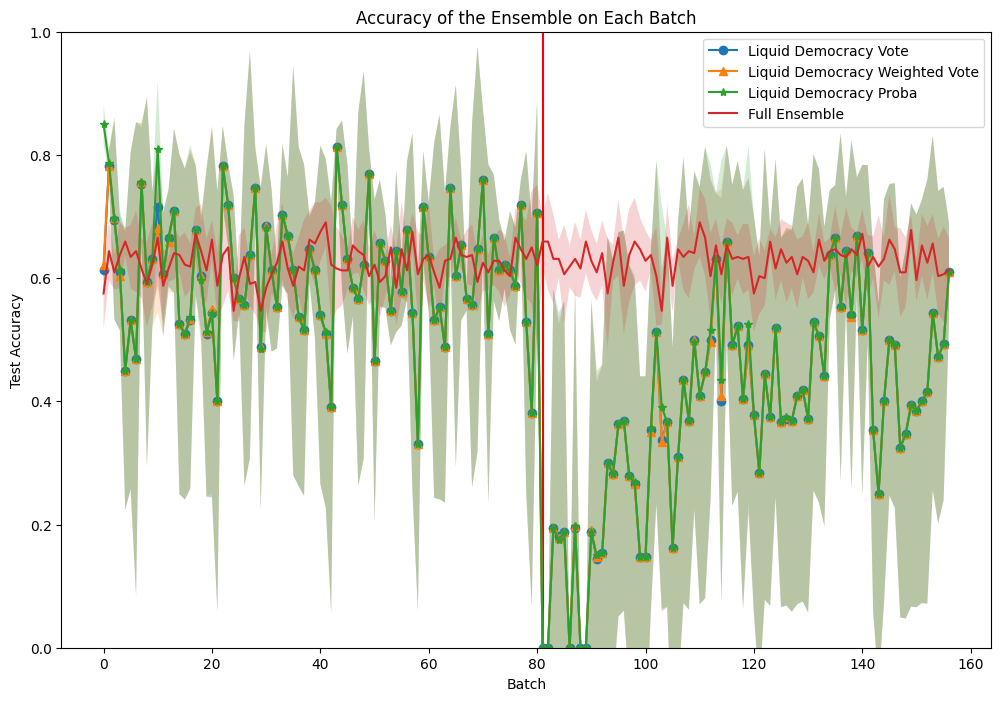

In [12]:
num_experiments = 5

all_liquid_dem_vote_accs = []
all_liquid_dem_weighted_vote_accs = []
all_liquid_dem_proba_accs = []
all_full_ensembel_accs = []

for i in range(num_experiments):

    test_loader, split_indices = ensemble.prepare_test_loaders()

    voters = [ens.Voter(model, i) for i, model in enumerate(models)]
    delegation_mechanism = ens.DelegationMechanism(batch_size=batch_size, window_size=20)

    liquid_dem_proba_accs = []
    liquid_dem_vote_accs = []
    liquid_dem_weighted_vote_accs = []
    full_ensemble_accs = []

    # Do predictions/delegations for all batches in training set
    for batch_idx, (data, target) in tqdm(enumerate(test_loader)):
        data, target = data.to(ensemble.device), target.to(ensemble.device)

        gurus = delegation_mechanism.get_gurus(voters)
        # print(len(gurus))
        # print()
        for guru in gurus:
            # print(guru.CI)
            predictions = guru.predict(data)

            point_wise_accuracies = (predictions == target).float().tolist()
            guru.accuracy.extend(point_wise_accuracies)

            guru.batch_accuracies.append(
                sum(point_wise_accuracies) / len(point_wise_accuracies)
            )
            guru.batch_accuracies_dict[batch_idx] = guru.batch_accuracies[-1]   # store accuracy on each single batch

        # get all of the gurus to predict then take the majority vote
        liquid_dem_preds = []
        for guru in gurus:
            guru_pred = guru.predict(data)

            # find number of delegations
            guru_weight = 0
            for delegator, delegee in delegation_mechanism.delegations.items():
                if delegee == guru.id:
                    guru_weight += 1
            if guru_weight == 0:
                guru_weight = 1
            for i in range(guru_weight):
                liquid_dem_preds.append(guru_pred)

        liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
        # take the majority vote
        liquid_dem_preds = custom_majority_vote(liquid_dem_preds)
        liquid_dem_weighted_vote_accs.append(
            (liquid_dem_preds == target).float().mean().item()
        )

        # get all of the gurus to predict then take the majority vote
        liquid_dem_preds = []
        for guru in gurus:
            liquid_dem_preds.append(guru.predict(data))
        liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
        # take the majority vote
        liquid_dem_preds = custom_majority_vote(liquid_dem_preds)
        liquid_dem_vote_accs.append((liquid_dem_preds == target).float().mean().item())

        probas = []
        for guru in gurus:
            probas.append(guru.predict_proba(data))
        probas = torch.stack(probas).transpose(0, 1)
        # take the average
        probas = torch.mean(probas, dim=1)
        # take the highest probability
        liquid_dem_preds = torch.argmax(probas, dim=1)

        liquid_dem_proba_accs.append((liquid_dem_preds == target).float().mean().item())

        # get all of the models to predict then take the majority vote
        full_ensemble_preds = []
        for model in models:
            full_ensemble_preds.append(model.predict(data))
        full_ensemble_preds = torch.stack(full_ensemble_preds).transpose(0, 1)
        # Apply the custom majority vote
        full_ensemble_preds = custom_majority_vote(full_ensemble_preds)

        full_ensemble_accs.append((full_ensemble_preds == target).float().mean().item())

        # print(delegation_mechanism.delegations)

        # add the CIs to the dictionary
        for voter in voters:
            UCBs_over_time[voter.id].append(voter.ucb_score)

        delegation_mechanism.t += len(data)

        delegation_mechanism.update_delegations(voters)

    all_liquid_dem_vote_accs.append(liquid_dem_vote_accs)
    all_liquid_dem_weighted_vote_accs.append(liquid_dem_weighted_vote_accs)
    all_liquid_dem_proba_accs.append(liquid_dem_proba_accs)
    all_full_ensembel_accs.append(full_ensemble_accs)

all_liquid_dem_vote_accs = np.array(all_liquid_dem_vote_accs)
all_liquid_dem_weighted_vote_accs = np.array(all_liquid_dem_weighted_vote_accs)
all_liquid_dem_proba_accs = np.array(all_liquid_dem_proba_accs)
all_full_ensembel_accs = np.array(all_full_ensembel_accs)

liquid_dem_vote_accs_mean = np.mean(all_liquid_dem_vote_accs, axis=0)
liquid_dem_vote_accs_std = np.std(all_liquid_dem_vote_accs, axis=0)

liquid_dem_weighted_vote_accs_mean = np.mean(all_liquid_dem_weighted_vote_accs, axis=0)
liquid_dem_weighted_vote_accs_std = np.std(all_liquid_dem_weighted_vote_accs, axis=0)

liquid_dem_proba_accs_mean = np.mean(all_liquid_dem_proba_accs, axis=0)
liquid_dem_proba_accs_std = np.std(all_liquid_dem_proba_accs, axis=0)

full_ensemble_accs_mean = np.mean(all_full_ensembel_accs, axis=0)
full_ensemble_accs_std = np.std(all_full_ensembel_accs, axis=0)


plt.figure(figsize=(12, 8))
for split in split_indices[:-1]:
    plt.axvline(x=split, color="r")


plt.plot(liquid_dem_vote_accs_mean, marker="o", label="Liquid Democracy Vote")
plt.fill_between(
    range(len(liquid_dem_vote_accs_mean)),
    liquid_dem_vote_accs_mean - liquid_dem_vote_accs_std,
    liquid_dem_vote_accs_mean + liquid_dem_vote_accs_std,
    alpha=0.2,
)

plt.plot(
    liquid_dem_weighted_vote_accs_mean,
    marker="^",
    label="Liquid Democracy Weighted Vote",
)
plt.fill_between(
    range(len(liquid_dem_weighted_vote_accs_mean)),
    liquid_dem_weighted_vote_accs_mean - liquid_dem_weighted_vote_accs_std,
    liquid_dem_weighted_vote_accs_mean + liquid_dem_weighted_vote_accs_std,
    alpha=0.2,
)

plt.plot(liquid_dem_proba_accs_mean, marker="*", label="Liquid Democracy Proba")
plt.fill_between(
    range(len(liquid_dem_proba_accs_mean)),
    liquid_dem_proba_accs_mean - liquid_dem_proba_accs_std,
    liquid_dem_proba_accs_mean + liquid_dem_proba_accs_std,
    alpha=0.2,
)

plt.plot(full_ensemble_accs_mean, label="Full Ensemble")
plt.fill_between(
    range(len(full_ensemble_accs_mean)),
    full_ensemble_accs_mean - full_ensemble_accs_std,
    full_ensemble_accs_mean + full_ensemble_accs_std,
    alpha=0.2,
)

plt.xlabel("Batch")
plt.ylabel("Test Accuracy")

# set lower y limit to 0
plt.ylim(0, 1)

plt.title("Accuracy of the Ensemble on Each Batch")
plt.legend()
plt.show()

In [13]:
# print the number of batches where the proba method outperformed all other methods
print(
    "Number of batches where the proba method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(liquid_dem_proba_accs_mean))
            if liquid_dem_proba_accs_mean[i] > liquid_dem_vote_accs_mean[i]
            and liquid_dem_proba_accs_mean[i] > liquid_dem_weighted_vote_accs_mean[i]
            and liquid_dem_proba_accs_mean[i] > full_ensemble_accs_mean[i]
        ]
    ),
)

# print the number of batches where the vote method outperformed all other methods
print(
    "Number of batches where the vote method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(liquid_dem_vote_accs_mean))
            if liquid_dem_vote_accs_mean[i] > liquid_dem_proba_accs_mean[i]
            and liquid_dem_vote_accs_mean[i] > liquid_dem_weighted_vote_accs_mean[i]
            and liquid_dem_vote_accs_mean[i] > full_ensemble_accs_mean[i]
        ]
    ),
)

# print the number of batches where the weighted vote method outperformed all other methods
print(
    "Number of batches where the weighted vote method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(liquid_dem_weighted_vote_accs_mean))
            if liquid_dem_weighted_vote_accs_mean[i] > liquid_dem_proba_accs_mean[i]
            and liquid_dem_weighted_vote_accs_mean[i] > liquid_dem_vote_accs_mean[i]
            and liquid_dem_weighted_vote_accs_mean[i] > full_ensemble_accs_mean[i]
        ]
    ),
)

# print the number of batches where the full ensemble method outperformed all other methods
print(
    "Number of batches where the full ensemble method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(full_ensemble_accs_mean))
            if full_ensemble_accs_mean[i] > liquid_dem_proba_accs_mean[i]
            and full_ensemble_accs_mean[i] > liquid_dem_vote_accs_mean[i]
            and full_ensemble_accs_mean[i] > liquid_dem_weighted_vote_accs_mean[i]
        ]
    ),
)

Number of batches where the proba method outperformed all other methods:  3
Number of batches where the vote method outperformed all other methods:  0
Number of batches where the weighted vote method outperformed all other methods:  0
Number of batches where the full ensemble method outperformed all other methods:  113
